# TDI Capstone Project, Part 3: Build models

**What happens in this notebook?**
* Two models are trained: one for major facilities, and one for minor facilties. These models, along with their feature importances, are saved to files for later use (STEPS 1-5).
  * All the required feature creation/engineering happens in the notebook. 
* The models are used to calculate the desired probabilities (for the current time). These probabilities are saved to a file for use in the web application (STEP 7). 
* The models are evaluated on records from three test years. The evaluation results are also saved to a file for use the web application (STEP 8). 

In [4]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import warnings

from external_variables import data_path,gov_dict,app_path

app_data_path = os.path.join(app_path,'data')
test_yrs = ['2007','2012','2018']

In [2]:
def load_processed_inspections(future_thresh=365):
    """ Load processed inspection data.
    
    Parameters: 
    -----------
    future_thresh = int. "Future" threshold used to create inspection file that you want to read. 
    """
    from external_variables import data_path
    filenamepath = os.path.join(data_path,'processed_inspections_futurethresh_'+str(future_thresh)+'.csv')
    dtypes = {'PGM_SYS_ID':'str','ACTIVITY_ID':'str','STATE_EPA_FLAG':'str','ACTIVITY_TYPE_CODE':'str',
              'ACTIVITY_TYPE_DESC':'str','COMP_MONITOR_TYPE_CODE':'str','COMP_MONITOR_TYPE_DESC':'str',
              'ACTUAL_END_DATE':'str','PROGRAM_CODES':'str','VIOL':'int','VIOL_ACTID':'str'}
              #'REGISTRY_ID':'str','days_prev_src':'float','days_prev_fac':'float','prev_viol_src':'bool',
              #'prev_viol_fac':'bool','num_prev_viol_src':'int','num_prev_viol_fac':'int'}
    inspections = pd.read_csv(filenamepath,parse_dates=['ACTUAL_END_DATE'],dtype=dtypes,index_col=0)
    inspections = inspections.sort_values(by=['PGM_SYS_ID','ACTUAL_END_DATE'],axis=0)
    #if isinstance(inspections['VIOL'].iloc[0],int): 
    #    inspections['VIOL'] = inspections['VIOL'].astype(bool)
    return inspections


def load_facility_info_ECHO(): 
    """Function for loading information on each EPA-regulated facility that is monitoried for air pollution.
    This information is derived from the larger ECHO_EXPORTER.csv (downloaded from EPA site), but is saved
    in a separate file. 
    
    Parameters: 
    -----------
    None
    """
    try: 
        facilities = pd.read_csv(os.path.join(data_path,'air_facility_info.csv'),dtype='str')
        
    except:

        # Identify columns that contain useful data, initialize dataframe to hold this info. 
        use_cols = list(range(0,70))+list(range(121,134))
        facilities = pd.read_csv(os.path.join(data_path,'ECHO_EXPORTER.csv'),nrows=1,dtype='str',
                                 usecols=use_cols).drop(index=0,axis=0)

        # Populate this new dataframe in chunks (file too big to load all at once) 
        facility_info = pd.read_csv(os.path.join(data_path,'ECHO_EXPORTER.csv'),chunksize=1e5,dtype='str',
                                    usecols=use_cols)
        for info in facility_info: 
            facilities = facilities.append(info[info['AIR_FLAG']=='Y'],ignore_index=True)

        # Save dataframe for future use. 
        facilities.to_csv(os.path.join(data_path,'air_facility_info.csv'),index=False)
        
    # Add column: Number of sources at facility. 
    facilities['FAC_NUM_SOURCES'] = facilities['AIR_IDS'].apply(lambda x: len(x.split(' '))) 
            
    return facilities

In [3]:
class add_registry_id(BaseEstimator,TransformerMixin):
    
    def __init__(self,facility_file='./data/ICIS-Air_downloads/ICIS-AIR_FACILITIES.csv'):
        self.facility_file = facility_file
        pass
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        facilities = pd.read_csv(self.facility_file,dtype='str')
        X_mrg = X.merge(facilities[['PGM_SYS_ID','REGISTRY_ID']],how='left',on='PGM_SYS_ID')
        return X_mrg

    
class time_since_prev(BaseEstimator,TransformerMixin):
    
    def __init__(self,date_col='ACTUAL_END_DATE',group_col='PGM_SYS_ID',new_col='time_since_prev'):
        self.date_col = date_col
        self.group_col = group_col
        self.new_col = new_col
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X = X.sort_values(by=[self.group_col,self.date_col],axis=0)
        if self.group_col is not None: 
            time_diff = X.groupby(self.group_col)[self.date_col].diff()/pd.Timedelta('1 days')
            time_diff[time_diff.isnull()]=np.NaN
            time_diff = time_diff.astype(float)
        else: 
            time_diff = X[self.date_col].diff()/pd.Timedelta('1 days')
            time_diff[time_diff.isnull()]=np.NaN
            time_diff = time_diff.astype(float)
        X[self.new_col] = time_diff
        return X
    

class add_historical_feats(BaseEstimator,TransformerMixin):
    """Transformer for determining inspection/violation history for a specific source."""
    
    def __init__(self,group_col='PGM_SYS_ID',viol_col='VIOL',ret_num_viol=False,new_col='num_viol_src'):
        self.group_col = group_col
        self.viol_col = viol_col
        self.ret_num_viol = ret_num_viol
        self.new_col = new_col
        
    def fit(self,X,y=None): 
        return self
    
    def transform(self,X,y=None): 
        prev_viol = (X.groupby(self.group_col)[self.viol_col].cumsum())
        prev_viol[X[self.viol_col]==True] = prev_viol-1
        if not self.ret_num_viol: 
            prev_viol = prev_viol>0
        X[self.new_col] = prev_viol
        return X
    
    
class add_facility_info(BaseEstimator,TransformerMixin):
    """Transformer for adding facility information."""
    
    def __init__(self,facilities,cols_to_add,merge_on='REGISTRY_ID'):
        self.merge_on = merge_on
        self.facilities = facilities
        self.cols_to_add = cols_to_add
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        fac_for_merge = self.facilities[self.cols_to_add+[self.merge_on]]
        fac_for_merge = fac_for_merge[fac_for_merge[self.merge_on].duplicated()==0] 
                # Some registry IDs evidently have multiple rows in the ECHO dataset. Need to remove extra. 
        inspect = X.merge(fac_for_merge,how='left',on=self.merge_on)
        return inspect

****
****
## STEP 1: Load inspection data, facility information

In [4]:
inspections = load_processed_inspections(future_thresh=90)

facilities_echo = load_facility_info_ECHO()

file_facilities_icis = os.path.join(data_path,'ICIS-Air_downloads','ICIS-AIR_FACILITIES.csv')
facilities_icis = pd.read_csv(file_facilities_icis,dtype='str')

****
****
## STEP 2: Add historical features
* Time since previous inspection at source
* Time since previous inspection at facility
* Number of previous violations at source
* Number of previous violations at facility
* Whether a previous violation has occurred at the source
* Whether a previous violation has occurred at the facility

In [5]:
pipe_before_split = Pipeline([
    ('add_reg_id',add_registry_id(facility_file=file_facilities_icis)),
    ('time_since_prev_insp_src',time_since_prev(date_col='ACTUAL_END_DATE',group_col='PGM_SYS_ID',new_col='time_since_prev_src')),
    ('time_since_prev_insp_fac',time_since_prev(date_col='ACTUAL_END_DATE',group_col='REGISTRY_ID',new_col='time_since_prev_fac')),
    ('past_viol_flag_src',add_historical_feats(group_col='PGM_SYS_ID',viol_col='VIOL',ret_num_viol=False,new_col='past_viol_flag_src')),
    ('past_viol_flag_fac',add_historical_feats(group_col='REGISTRY_ID',viol_col='VIOL',ret_num_viol=False,new_col='past_viol_flag_fac')),
    ('past_viol_num_src',add_historical_feats(group_col='PGM_SYS_ID',viol_col='VIOL',ret_num_viol=True,new_col='past_viol_num_src')),
    ('past_viol_num_fac',add_historical_feats(group_col='PGM_SYS_ID',viol_col='VIOL',ret_num_viol=True,new_col='past_viol_num_fac')),
])

insp1 = pipe_before_split.fit_transform(inspections)
insp1 = insp1.drop('time_since_prev',axis=1)
insp1.head()

,PGM_SYS_ID,ACTIVITY_ID,STATE_EPA_FLAG,ACTIVITY_TYPE_CODE,ACTIVITY_TYPE_DESC,COMP_MONITOR_TYPE_CODE,COMP_MONITOR_TYPE_DESC,ACTUAL_END_DATE,PROGRAM_CODES,VIOL,VIOL_ACTID,REGISTRY_ID,time_since_prev_src,time_since_prev_fac,past_viol_flag_src,past_viol_flag_fac,past_viol_num_src,past_viol_num_fac
628158,PR0000007209700009,3400721932,S,INS,Inspection/Evaluation,POR,PCE On-Site Record/Report Review,2005-07-08,"CAASIP, CAATVP",0,NaN,110000307766,NaN,NaN,False,False,0,0
628292,PR0000007211300013,3400713831,E,INS,Inspection/Evaluation,FOO,FCE On-Site,2004-09-22,"CAANSPS, CAASIP, CAATVP",0,NaN,110000307775,NaN,NaN,False,False,0,0
628293,PR0000007211300013,3400713834,S,INS,Inspection/Evaluation,FOO,FCE On-Site,2005-07-19,"CAASIP, CAATVP",0,NaN,110000307775,300.0,300.0,False,False,0,0
628294,PR0000007211300013,3400713838,S,INS,Inspection/Evaluation,POR,PCE On-Site Record/Report Review,2006-09-14,"CAASIP, CAATVP",0,NaN,110000307775,422.0,422.0,False,False,0,0
628295,PR0000007211300013,3400713839,S,INS,Inspection/Evaluation,POR,PCE On-Site Record/Report Review,2007-04-11,"CAASIP, CAATVP",0,NaN,110000307775,209.0,209.0,False,False,0,0


***
***
## STEP 3: Divide into separate datasets for major and minor facilities

In [6]:
class use_major_minor(BaseEstimator,TransformerMixin):
    """Transformer for selecting only major facilities, minor facilities, or both."""
    
    def __init__(self,major_or_minor='both'):
        self.major_or_minor = major_or_minor
        
    def fit(self,X,y=None): 
        return self
    
    def transform(self,X,y=None): 
        if self.major_or_minor == 'major': 
            bool_select = X['FAC_MAJOR_FLAG'].isin(['Y',True,1])
            X = X.drop('FAC_MAJOR_FLAG',axis=1)
            return X[bool_select]
        elif self.major_or_minor == 'minor': 
            bool_select = ~X['FAC_MAJOR_FLAG'].isin(['Y',True,1])
            X = X.drop('FAC_MAJOR_FLAG',axis=1)
            return X[bool_select]
        return X

In [7]:
pipe_maj_min = Pipeline([
    ('add_major_minor',add_facility_info(facilities_echo,['FAC_MAJOR_FLAG'],merge_on='REGISTRY_ID')),
    ('use_maj_min',use_major_minor(major_or_minor='major')),
])
insp_maj = pipe_maj_min.fit_transform(insp1) 

pipe_maj_min = Pipeline([
    ('add_major_minor',add_facility_info(facilities_echo,['FAC_MAJOR_FLAG'],merge_on='REGISTRY_ID')),
    ('use_maj_min',use_major_minor(major_or_minor='minor')),
])
insp_min = pipe_maj_min.fit_transform(insp1) 

****
****
## STEP 4: Build model for major facilities

### Separate inspection data into X and y

In [8]:
y = insp_maj['VIOL']
X = insp_maj.drop('VIOL',axis=1)

### Split into training/test sets
* Test set: inspections from 2007, 2012, 2018. 
* Training set: all other years. 

In [9]:
def train_test_split_year(X,y,test_yrs=['2007','2012','2018'],date_col='ACTUAL_END_DATE'):
    test_bools = X[date_col].dt.year.isin([int(yr) for yr in test_yrs])
    X_test = X[test_bools]
    X_train = X[~test_bools]
    if not y is None: 
        y_test = y[test_bools]
        y_train = y[~test_bools]
        return X_train,X_test,y_train,y_test
    else: 
        return X_train,X_test

In [10]:
X_train,X_test,y_train,y_test = train_test_split_year(X,y,test_yrs=test_yrs,
                                                      date_col='ACTUAL_END_DATE')

### Add features
* Basic facility information (from ECHO and ICIS-Air database)
* Number of active facilities in state
* Number of active facilities in county
* Facility's industry
* Various features engineered from NEI emissions estimates: 2007, 2011, 2014
  * Emissions of `poll_codes` in 2007, 2011, and 2014
  * Normalized emissions of the industry's three primary pollutants in 2007, 2011, and 2014
  * Percent changes in normalized emissions of primary pollutants from 2007-2011, 2011-2014, 2007-2014, and interval closest to the date of the inspection
* Political party of state's governor, as of April 2019

In [11]:
class standardize_echo_feats(BaseEstimator,TransformerMixin):
    """Transformer for standardizing format of features from the ECHO database"""
    
    def __init__(self,flag_cols,count_cols,to_float_cols):
        self.flag_cols = flag_cols
        self.count_cols = count_cols
        self.to_float_cols = to_float_cols
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        
        for flag in self.flag_cols: 
            X[flag] = X[flag].apply(lambda x: x=='Y' or x==1)
        
        for count in self.count_cols: 
            X[count] = X[count].astype(float)
            X[count] = X[count].replace(to_replace=np.nan,value=0)
        
        for tf in self.to_float_cols: 
            X[tf] = X[tf].astype(float)      
            
        return X


class add_facilities_in_state(BaseEstimator,TransformerMixin):
    """Transformer for adding feature: number of facilities in state"""
    
    def __init__(self,facilities):
        self.facilities = facilities

    def fit(self,X,y=None):
        return self

    def transform(self,X,y=None):
        facil = self.facilities[(self.facilities['FAC_ACTIVE_FLAG']=='Y')]
        grouped = pd.DataFrame({'facilities_in_state':facil.groupby('FAC_STATE')['REGISTRY_ID'].count()})
        X = X.merge(grouped,how='left',left_on='FAC_STATE',right_index=True)
        return X
    

class add_facilities_in_county(BaseEstimator,TransformerMixin):
    """Transformer for adding feature: number of facilities in county"""
    
    def __init__(self,facilities):
        self.facilities = facilities
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        facil = self.facilities[(self.facilities['FAC_ACTIVE_FLAG']=='Y')]
        grouped = pd.DataFrame({'facilities_in_county':
                                facil.groupby('FAC_FIPS_CODE')['REGISTRY_ID'].count()})
        X = X.merge(grouped,how='left',left_on='FAC_FIPS_CODE',right_index=True)
        return X

    
class add_industry(BaseEstimator,TransformerMixin):
    """Transformer for adding feature: industry of regulated facility"""
    
    def __init__(self):
        return None

    def fit(self,X,y=None):
        return self

    def transform(self,X,y=None):
        from external_variables import naics_dict
        naics_lookup = pd.DataFrame({'FIRST_NAICS':list(naics_dict.keys()),
                                     'FAC_INDUSTRY':list(naics_dict.values())})
        X['FIRST_NAICS'] = X['NAICS_CODES'].apply(lambda x: str(x).split(' ')[0][0:2])
        X = X.merge(naics_lookup,how='left',on='FIRST_NAICS')
        X = X.drop('FIRST_NAICS',axis=1)
        X['FAC_INDUSTRY'] = X['FAC_INDUSTRY'].fillna('unknown')
        return X
    
    
class add_NEI_emissions(BaseEstimator,TransformerMixin):
    """Transformer for adding features: total emissions of various pollutants from NEI database."""
    
    def __init__(self,poll_codes,yrs=['2008','2011','2014'],calc_primary_emiss=True):
        self.poll_codes = poll_codes
        self.yrs = yrs
        self.calc_primary = calc_primary_emiss
        return None

    def fit(self,X,y=None):
        return self

    def transform(self,X,y=None):
        
        nei_emissions = pd.read_csv(os.path.join(data_path,'processed_nei_emissions_by_facility.csv'),
                                    dtype={'REGISTRY_ID':'str'},index_col=0)
        nei_emissions = nei_emissions.drop(['FAC_INDUSTRY','NAICS_CODES'],axis=1)
        X = X.merge(nei_emissions,how='left',on='REGISTRY_ID')  
        
        return X

class add_NEI_diffs(BaseEstimator,TransformerMixin):
    
    def __init__(self,yrs): 
        self.yrs = yrs
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        from itertools import combinations
        combs = combinations(self.yrs,2)
        for comb in combs: 
            for pcode in ['1','2','3']: 
                emis_diff = (X['poll'+pcode+'_'+comb[1]]- \
                             X['poll'+pcode+'_'+comb[0]])/ \
                             X['poll'+pcode+'_'+comb[1]]
                col_name = ':'.join(['diff','poll'+pcode,comb[0][-2:]+comb[1][-2:]])
                X[col_name]=emis_diff
        return X
    
    
class pick_NEI_diffs(BaseEstimator,TransformerMixin):
    """Transformer to choose which emissions changes we want to use in our model--the changes that 
    occurred over the NEI1-NEI2 period which has a center closest to the date of the inspection. 
    """
    def __init__(self): 
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        diff_dates = {'0811':pd.Timestamp(year=2009,month=6,day=30),
                      '1114':pd.Timestamp(year=2012,month=6,day=30)}
        diff_poll1,diff_poll2,diff_poll3 = [],[],[]
        for i,row in X.iterrows(): 
            if abs(row['ACTUAL_END_DATE']-diff_dates['0811'])<abs(row['ACTUAL_END_DATE']-diff_dates['1114']): 
                diff_poll1.append(row['diff:poll1:0811'])
                diff_poll2.append(row['diff:poll2:0811'])
                diff_poll3.append(row['diff:poll3:0811'])
            else: 
                diff_poll1.append(row['diff:poll1:1114'])
                diff_poll2.append(row['diff:poll2:1114'])
                diff_poll3.append(row['diff:poll3:1114'])
        X['poll1_diff'] = diff_poll1
        X['poll2_diff'] = diff_poll2
        X['poll3_diff'] = diff_poll3
        return X

    
class pick_NEI_nearest(BaseEstimator,TransformerMixin):
    """Transformer to choose which pollutant values we want to use in our model--the values from the 
    National Emissions Inventory that was released closest to the date of the inspection. 
    """
    def __init__(self): 
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        nei_dates = {'2008':pd.Timestamp(year=2008,month=1,day=1),
                     '2011':pd.Timestamp(year=2011,month=1,day=1),
                     '2014':pd.Timestamp(year=2014,month=1,day=1)}
        poll1,poll2,poll3 = [],[],[]
        for i,row in X.iterrows(): 
            if (abs(row['ACTUAL_END_DATE']-nei_dates['2008'])<=abs(row['ACTUAL_END_DATE']-nei_dates['2011']) and
                abs(row['ACTUAL_END_DATE']-nei_dates['2008'])<abs(row['ACTUAL_END_DATE']-nei_dates['2014'])): 
                poll1.append(row['poll1_2008'])
                poll2.append(row['poll2_2008'])
                poll3.append(row['poll3_2008'])
            elif (abs(row['ACTUAL_END_DATE']-nei_dates['2011'])<=abs(row['ACTUAL_END_DATE']-nei_dates['2008']) and
                  abs(row['ACTUAL_END_DATE']-nei_dates['2011'])<abs(row['ACTUAL_END_DATE']-nei_dates['2014'])): 
                poll1.append(row['poll1_2011'])
                poll2.append(row['poll2_2011'])
                poll3.append(row['poll3_2011'])
            else: 
                poll1.append(row['poll1_2014'])
                poll2.append(row['poll2_2014'])
                poll3.append(row['poll3_2014'])
        X['poll1_near'] = poll1
        X['poll2_near'] = poll2
        X['poll3_near'] = poll3
        return X
    

class governors_party(BaseEstimator,TransformerMixin):
    """Transformer to add column with party affiliation of state's governor."""
    def __init__(self,gov_dict): 
        self.gov_dict = gov_dict
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X['gov_party'] = X['FAC_STATE'].map(self.gov_dict)
        return X

In [12]:
cols_from_echo = ['FAC_NAME','FAC_STATE','FAC_COUNTY','FAC_ZIP','FAC_LAT','FAC_LONG','FAC_FIPS_CODE',
               'FAC_DERIVED_CB2010','FAC_PERCENT_MINORITY','FAC_POP_DEN','FAC_MAJOR_FLAG','FAC_ACTIVE_FLAG',
               'CAA_PERMIT_TYPES','CAA_EVALUATION_COUNT','CAA_DAYS_LAST_EVALUATION',
               'CAA_INFORMAL_COUNT','FAC_FORMAL_ACTION_COUNT','FAC_NUM_SOURCES','FAC_INDIAN_CNTRY_FLG',
               'FAC_FEDERAL_FLG','FAC_US_MEX_BORDER_FLG','FAC_CHESAPEAKE_BAY_FLG']

cols_from_icis = ['FACILITY_TYPE_CODE','SIC_CODES','NAICS_CODES']

flags = ['FAC_MAJOR_FLAG','FAC_ACTIVE_FLAG','FAC_INDIAN_CNTRY_FLG','FAC_FEDERAL_FLG',
         'FAC_US_MEX_BORDER_FLG','FAC_CHESAPEAKE_BAY_FLG']
counts = ['CAA_EVALUATION_COUNT','CAA_INFORMAL_COUNT','FAC_FORMAL_ACTION_COUNT']
to_float = ['FAC_PERCENT_MINORITY','FAC_POP_DEN','CAA_DAYS_LAST_EVALUATION','FAC_LAT','FAC_LONG']

poll_codes = ['NOX','PM10-PRI','PM25-PRI','PMFINE','SO2','SO4','VOC','CO','NH3']
nei_yrs = ['2008','2011','2014']

add_feats_pipe = Pipeline([
    ('add_info_echo',add_facility_info(facilities_echo,cols_from_echo,merge_on='REGISTRY_ID')),
    ('add_info_icis',add_facility_info(facilities_icis,cols_from_icis,merge_on='PGM_SYS_ID')),
    ('std_echo',standardize_echo_feats(flags,counts,to_float)),
    ('add_fac_state',add_facilities_in_state(facilities_echo)),
    ('add_fac_county',add_facilities_in_county(facilities_echo)),
    ('add_industry',add_industry()),
    ('add_nei',add_NEI_emissions(poll_codes,yrs=nei_yrs,calc_primary_emiss=True)),
    ('add_nei_diffs',add_NEI_diffs(yrs=nei_yrs)),
    ('pick_nei_near',pick_NEI_nearest()),
    ('pick_nei_diffs',pick_NEI_diffs()),
    ('add_gov_party',governors_party(gov_dict)),
])

X_train1 = add_feats_pipe.fit_transform(X_train)

### Prepare the data for entrance into ML model
* Select variables that I want to consider for the machine learning model. 
* Impute numerical variables
* Encode categorical variables
* Convert binary variables from booleans to integers

In [13]:
class select_potential_features(BaseEstimator,TransformerMixin):
    
    def __init__(self,sel_vbls):
        self.sel_vbls = sel_vbls
        return
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X = X[self.sel_vbls]
        return X
    
    
class impute_numerical(BaseEstimator,TransformerMixin):
    
    def __init__(self,num_vbls,keep_thresh=0.02):
        self.num_vbls = num_vbls
        self.keep_thresh = keep_thresh
        return
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        
        from sklearn.preprocessing import Imputer
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            imputer = Imputer(strategy="median")
            X = X.replace([np.inf, -np.inf], np.nan)
            X[self.num_vbls] = imputer.fit_transform(X[self.num_vbls])
        return X

    
class encode_categorical(BaseEstimator,TransformerMixin):
    
    def __init__(self,cat_vbls):
        self.cat_vbls = cat_vbls
        return
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        from sklearn.preprocessing import OneHotEncoder
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            encoders = []
            for pred in self.cat_vbls: 
                X[pred][X[pred].apply(str)=='nan'] = 'undetermined'
                encoder = OneHotEncoder(sparse=False)
                encoded = encoder.fit_transform(np.asarray(X[pred]).reshape(-1,1))
                encoders.append(encoder)
                for i,cat in enumerate(encoder.categories_[0]): 
                    X[cat] = encoded[:,i]
                X = X.drop(pred,axis=1)
        return X
    
    
class make_binary_1_0(BaseEstimator,TransformerMixin):
    
    def __init__(self,bin_vbls):
        self.bin_vbls = bin_vbls
        return
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for bin_vbl in self.bin_vbls: 
                X[bin_vbl] = X[bin_vbl].astype(int)
        return X 

In [14]:
from sklearn.preprocessing import StandardScaler

NEI_cols = ['poll1_near', 'poll2_near','poll3_near', 'poll1_diff', 'poll2_diff', 'poll3_diff']
num_predictors = ['time_since_prev_fac','FAC_PERCENT_MINORITY','FAC_POP_DEN','FAC_NUM_SOURCES',
                  'facilities_in_state','facilities_in_county','past_viol_num_fac']+NEI_cols
cat_predictors = ['FAC_INDUSTRY','gov_party']
bin_predictors = ['FAC_INDIAN_CNTRY_FLG','FAC_FEDERAL_FLG', 'FAC_US_MEX_BORDER_FLG', 
                  'FAC_CHESAPEAKE_BAY_FLG']
predictors = num_predictors+cat_predictors+bin_predictors

model_prep_pipe_maj = Pipeline([
    ('feat_select',select_potential_features(predictors)),
    ('impute_num',impute_numerical(num_predictors)),
    ('encode_cat',encode_categorical(cat_predictors)),
    ('make_bin',make_binary_1_0(bin_predictors)),
#    ('std_scal',StandardScaler()),
])

X_train2 = model_prep_pipe_maj.fit_transform(X_train1)
#X_train2.head()

### Balance classes using SMOTE
[Smote](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#r001eabbe5dd7-1) adds synthetic instances of the under-represented class by selecting two or more similar instances (neighbors), and then creating a new instance as a linear combination of the instances with varying mixing factors. 

In [19]:
# Shuffle X and y
from sklearn.utils import shuffle
X_train_f,y_train_f = shuffle(X_train2,y_train,random_state=42)

# Split into train and test again... so that we can see how much rebalancing really helps on a dataset 
# that hasn't been rebalanced yet. 
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_train_f, y_train_f, test_size=0.2, random_state=42, 
                                          stratify=y_train_f)

# Rebalance
from imblearn.over_sampling import SMOTE
smote_insp = SMOTE(sampling_strategy=1,k_neighbors=5)
X_reb,y_reb = smote_insp.fit_resample(X_tr,y_tr)

#from imblearn.over_sampling import RandomOverSampler
#oversample_insp = RandomOverSampler(ratio=1, random_state=42)
#X_reb,y_reb = oversample_insp.fit_resample(X_tr,y_tr)

### Pick the model

#### Grid search to identify best parameters
* Use rebalanced portion (80%) of the original, full training set

In [20]:
# Import models
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression

# Grid search to find the best parameters
#RFclf_maj = RandomForestClassifier(random_state=42,n_estimators=10)
#pg = {'max_depth':[2**i for i in range(4,8)],
#      'min_samples_leaf':[6**i for i in range(7)]}
#RFclf_maj_gs = GridSearchCV(RFclf_maj,pg,cv=3)
#RFclf_maj_gs.fit(X_reb,y_reb)
#RFclf_maj_gs.best_params_

# Random forest
#RFclf_single = RandomForestClassifier(random_state=42,max_depth=7,min_samples_split=500,n_estimators=10)
#y_method_all_vals = cross_val_predict(RFclf_single,X_reb,y_reb,cv=3,method='predict_proba')
#y_method_vals = y_method_all_vals[:,1]

# Bernoulli Naive bayes
#NBclf_single = BernoulliNB(alpha=100)
#y_method_all_vals = cross_val_predict(NBclf_single,X_train2,y_train,cv=3,method='predict_proba')
#y_method_vals = y_method_all_vals[:,1]

# Complement Naive Bayes
#from sklearn.naive_bayes import ComplementNB
#NBclf_single = ComplementNB(alpha=100, fit_prior=True, class_prior=None, norm=False)
#y_method_all_vals = cross_val_predict(NBclf_single,X_train2,y_train,cv=3,method='predict_proba')
#y_method_vals = y_method_all_vals[:,1]

# Multinomial NB: 
#from sklearn.naive_bayes import MultinomialNB
#NBclf_single = MultinomialNB(alpha=100, fit_prior=True, class_prior=None)
#y_method_all_vals = cross_val_predict(NBclf_single,X_train2,y_train,cv=3,method='predict_proba')
#y_method_vals = y_method_all_vals[:,1]

# Gaussian NB
#from sklearn.naive_bayes import GaussianNB
#NBclf_single = GaussianNB(priors=None, var_smoothing=1e-8)
#y_method_all_vals = cross_val_predict(NBclf_single,X_train2,y_train,cv=3,method='predict_proba')
#y_method_vals = y_method_all_vals[:,1]

# Try random forest with grid search. No luck. 
#pg = {'max_depth':[2**i for i in range(6)],
#      'min_samples_leaf':[6**i for i in range(7)]}
#RFclf = GridSearchCV(RandomForestClassifier(random_state=42),pg,cv=3)
#RFclf.fit(X_train2,y_train)

#### Estimate how well the model performs on an unseen set
* Train on the rebalanced portion (80%) of the original, full training set
* Test on the unbalanced portion (20%) of the original, full training set

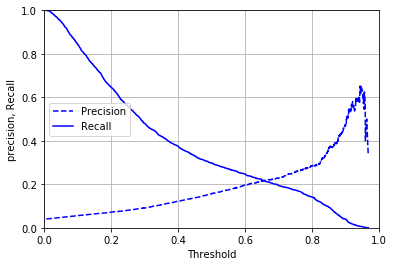

,features,importance
6,past_viol_num_fac,0.454442
18,Manufacturing,0.091807
22,Utilities,0.082652
9,poll3_near,0.059631
21,Transportation and Warehousing,0.059509
7,poll1_near,0.031814
19,"Mining, Quarrying, and Oil and Gas Extraction",0.024682
15,Administrative and Support and Waste Managemen...,0.023773
3,FAC_NUM_SOURCES,0.023167
4,facilities_in_state,0.018738


In [21]:
from sklearn.feature_selection import SelectFromModel

feat_sel_clf = RandomForestClassifier(random_state=42,n_estimators=10,max_depth=20,min_samples_leaf=100)
final_clf = RandomForestClassifier(random_state=42,n_estimators=10,max_depth=20,min_samples_leaf=100)
RFclf_maj = Pipeline([
    ('feat_sel',SelectFromModel(feat_sel_clf,threshold=0.001)),
    ('clf',final_clf),
])
    
#RFclf_maj = RandomForestClassifier(random_state=42,n_estimators=10,**RFclf_maj_gs.best_params_)
#RFclf_maj = ExtraTreesClassifier(random_state=42,n_estimators=20,max_depth=20,min_samples_leaf=100)
#RFclf_maj = LogisticRegression(penalty='l1',C=0.01,solver='saga')
RFclf_maj.fit(X_reb,y_reb)
y_method_all_vals = RFclf_maj.predict_proba(X_te)
y_method_vals = y_method_all_vals[:,1]

precisions,recalls,thresholds = precision_recall_curve(y_te,y_method_vals)
xlim = [0,1]
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds,xlim=[-20000,20000]):
    plt.figure()
    plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds,recalls[:-1],'b-',label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('precision, Recall')
    plt.legend(loc='center left')
    plt.ylim([0,1])
    plt.xlim(xlim)
    plt.grid()
    return

plot_precision_recall_vs_threshold(precisions,recalls,thresholds,xlim=xlim)
plt.show()

feat_imps = pd.DataFrame({'features':X_train2.columns[RFclf_maj.named_steps['feat_sel'].get_support()],
                          'importance':RFclf_maj.named_steps['clf'].feature_importances_})
feat_imps.sort_values(by='importance',axis=0,ascending=False)

### Train the model one final time, save
* This time, rebalance the entire training set, use that entire rebalanced set to train the model

In [ ]:
def save_feature_importances(training_df, estimator_pipe): 
    """Given training dataset and model feature importances, saves feature importances to CSV"""
    feat_imps = pd.DataFrame({'features':training_df.columns[estimator_pipe.named_steps['feat_sel'].get_support()],
                              'importance':estimator_pipe.named_steps['clf'].feature_importances_})
    feat_imps = feat_imps.sort_values(by='importance',axis=0,ascending=False)
    feat_imps.to_csv(os.path.join(app_data_path,'feature_importances_major.csv'))
    return os.path.join(app_data_path,'feature_importances_major.csv')

In [22]:
from joblib import dump

smote_insp = SMOTE(sampling_strategy=1,k_neighbors=5)
X_reb_f,y_reb_f = smote_insp.fit_resample(X_train_f,y_train_f)
RFclf_maj.fit(X_reb_f,y_reb_f)

# Save model
dump(RFclf_maj,os.path.join('.','models','model_major_facilities.joblib'))

# Save feature importances
filename = save_feature_importances(X_train2, RFclf_maj)


****
****
## STEP 5: Build model for minor facilities

Do pretty much the same thing as for the major facilities; we'll just leave out some emissions-related features at the end (due to data scarcity issues). 

### Separate into X and y

In [23]:
y = insp_min['VIOL']
X = insp_min.drop('VIOL',axis=1)

### Divide into training and test sets
Same years as for major facilities

In [24]:
X_train,X_test,y_train,y_test = train_test_split_year(X,y,test_yrs=[2007,2012,2018],
                                                      date_col='ACTUAL_END_DATE')

### Add features

In [25]:
X_train1 = add_feats_pipe.transform(X_train)

### Prepare data for model
Select features we'll consider for the model, impute numerical features, encode categorical features, and convert binary features into integers. 

In [27]:
num_predictors = ['time_since_prev_fac','FAC_PERCENT_MINORITY','FAC_POP_DEN','FAC_NUM_SOURCES',
                  'facilities_in_state','facilities_in_county','past_viol_num_fac']
cat_predictors = ['FAC_INDUSTRY']
bin_predictors = ['FAC_INDIAN_CNTRY_FLG','FAC_FEDERAL_FLG', 'FAC_US_MEX_BORDER_FLG', 
                  'FAC_CHESAPEAKE_BAY_FLG']
predictors = num_predictors+cat_predictors+bin_predictors

model_prep_pipe_min = Pipeline([
    ('feat_select',select_potential_features(predictors)),
    ('impute_num',impute_numerical(num_predictors)),
    ('encode_cat',encode_categorical(cat_predictors)),
    ('make_bin',make_binary_1_0(bin_predictors))
])

X_train2 = model_prep_pipe_min.fit_transform(X_train1)

### Balance classes using SMOTE 

In [28]:
# Shuffle X and y
from sklearn.utils import shuffle
X_train_f,y_train_f = shuffle(X_train2,y_train,random_state=42)

# Split into train and test again... so that we can see how much rebalancing really helps on a dataset 
# that hasn't been rebalanced yet. 
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_train_f, y_train_f, test_size=0.2, random_state=42, 
                                          stratify=y_train_f)
# Rebalance
from imblearn.over_sampling import SMOTE
smote_insp = SMOTE(sampling_strategy=1,k_neighbors=5)
X_reb,y_reb = smote_insp.fit_resample(X_tr,y_tr)


#from imblearn.over_sampling import RandomOverSampler
#oversample_insp = RandomOverSampler(ratio=1, random_state=42)
#X_reb,y_reb = oversample_insp.fit_resample(X_tr,y_tr)

### Pick the model
* Use rebalanced training set--this is 80% of the full training set. 

In [29]:
# Import models
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

# Grid search to find the best hyperparameters
#RFclf_min = RandomForestClassifier(random_state=42,n_estimators=10)
#pg = {'max_depth':[2**i for i in range(6)],
#      'min_samples_leaf':[6**i for i in range(7)]}
#RFclf_min_gs = GridSearchCV(RFclf_min,pg,cv=3)
#RFclf_min_gs.fit(X_reb,y_reb)

# Random forest
#RFclf_min = RandomForestClassifier(random_state=42,max_depth=7,min_samples_split=500,n_estimators=10)
#y_method_all_vals = cross_val_predict(RFclf_min,X_reb,y_reb,cv=3,method='predict_proba')
#y_method_vals = y_method_all_vals[:,1]

# Bernoulli Naive bayes
#NBclf_single = BernoulliNB(alpha=100)
#y_method_all_vals = cross_val_predict(NBclf_single,X_train2,y_train,cv=3,method='predict_proba')
#y_method_vals = y_method_all_vals[:,1]

# Complement Naive Bayes
#from sklearn.naive_bayes import ComplementNB
#NBclf_single = ComplementNB(alpha=100, fit_prior=True, class_prior=None, norm=False)
#y_method_all_vals = cross_val_predict(NBclf_single,X_train2,y_train,cv=3,method='predict_proba')
#y_method_vals = y_method_all_vals[:,1]

# Multinomial NB: 
#from sklearn.naive_bayes import MultinomialNB
#NBclf_single = ComplementNB(alpha=100, fit_prior=True, class_prior=None)
#y_method_all_vals = cross_val_predict(NBclf_single,X_train2,y_train,cv=3,method='predict_proba')
#y_method_vals = y_method_all_vals[:,1]

# Gaussian NB
#from sklearn.naive_bayes import GaussianNB
#NBclf_single = GaussianNB(priors=None, var_smoothing=1e-8)
#y_method_all_vals = cross_val_predict(NBclf_single,X_train2,y_train,cv=3,method='predict_proba')
#y_method_vals = y_method_all_vals[:,1]


# Try random forest with grid search. No luck. 
#pg = {'max_depth':[2**i for i in range(6)],
#      'min_samples_leaf':[6**i for i in range(7)]}
#RFclf = GridSearchCV(RandomForestClassifier(random_state=42),pg,cv=3)
#RFclf.fit(X_train2,y_train)

### Determine how well the model performs on an unseen dataset
* Train the model on the rebalanced portion (80%) of the full test set
* Test the model on the unbalanced portion of the training set (20%)

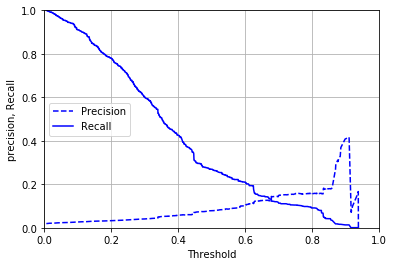

,features,importance
2,past_viol_num_fac,0.251154
4,Manufacturing,0.225878
0,facilities_in_state,0.180318
1,facilities_in_county,0.117531
3,FAC_CHESAPEAKE_BAY_FLG,0.082641
5,"Mining, Quarrying, and Oil and Gas Extraction",0.074827
6,Other Services (except Public Administration),0.034932
7,Wholesale Trade,0.032719


In [30]:
#RFclf_min = RandomForestClassifier(random_state=42,n_estimators=10,**RFclf_min_gs.best_params_)
feat_sel_clf = RandomForestClassifier(random_state=42,n_estimators=10,max_depth=20,min_samples_leaf=100)
final_clf = RandomForestClassifier(random_state=42,n_estimators=10,max_depth=20,min_samples_leaf=100)
RFclf_min = Pipeline([
    ('feat_sel',SelectFromModel(feat_sel_clf,threshold='mean')),
    ('clf',final_clf),
])

RFclf_min.fit(X_reb,y_reb)
y_method_all_vals = RFclf_min.predict_proba(X_te)
y_method_vals = y_method_all_vals[:,1]

precisions,recalls,thresholds = precision_recall_curve(y_te,y_method_vals)
xlim = [0,1]
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds,xlim=[-20000,20000]):
    plt.figure()
    plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds,recalls[:-1],'b-',label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('precision, Recall')
    plt.legend(loc='center left')
    plt.ylim([0,1])
    plt.xlim(xlim)
    plt.grid()
    return

plot_precision_recall_vs_threshold(precisions,recalls,thresholds,xlim=xlim)
plt.show()

feat_imps = pd.DataFrame({'features':X_train2.columns[RFclf_min.named_steps['feat_sel'].get_support()],
                          'importance':RFclf_min.named_steps['clf'].feature_importances_})
feat_imps.sort_values(by='importance',axis=0,ascending=False)

### Re-train the chosen model on the entire minor facilities dataset

In [31]:
from joblib import dump

smote_insp = SMOTE(sampling_strategy=1,k_neighbors=5)
X_reb_f,y_reb_f = smote_insp.fit_resample(X_train_f,y_train_f)
RFclf_min.fit(X_reb_f,y_reb_f)

# Save the model
dump(RFclf_min,os.path.join('.','models','model_minor_facilities.joblib'))

# Save feature importances
feat_imps = pd.DataFrame({'features':X_train2.columns[RFclf_min.named_steps['feat_sel'].get_support()],
                          'importance':RFclf_min.named_steps['clf'].feature_importances_})
feat_imps = feat_imps.sort_values(by='importance',axis=0,ascending=False)
feat_imps.to_csv(os.path.join(app_data_path,'feature_importances_minor.csv'))


****
****
## STEP 6: Estimate p(viol) as a function of model risk score
For major facilities, minor facilities, and both together. Save to file. 

In [32]:
def est_probs_viol(test_data,add_feats_pipe,model_prep_pipe,model):
    """Function to estimate p(violation) for inspections with risk scores in different intervals 
    (0-1 by 0.01, interval = +/- 0.05). 
    """
    # Get model risks for test dataset. 
    test_data = add_feats_pipe.transform(test_data)
    test_data_fin = model_prep_pipe.transform(test_data)
    pred_probas = model.predict_proba(test_data_fin)
    test_data['Risk'] = pred_probas[:,1]
    
    # Estimate probabilities for different risk score bins
    p_vec = np.linspace(0,1,101)
    rate,counts = [],[]
    for pr in p_vec: 
        insp_interest = test_data['VIOL'][(test_data['Risk']>=max(pr-0.05,0)) & (test_data['Risk']<min(pr+0.05,1))]
        rate.append(insp_interest.sum()/insp_interest.count())
        counts.append(insp_interest.count())
    
    probs_viol = pd.DataFrame({
        'risk': list(p_vec),
        'prob': rate,
        'counts': counts,
    })
    
    return probs_viol

In [33]:
# Load models
from joblib import load
clf_major = load(os.path.join('.','models','model_major_facilities.joblib'))
clf_minor = load(os.path.join('.','models','model_minor_facilities.joblib'))

# Risk score->probability conversion for major facilities
_,maj_test,_,_ = train_test_split_year(insp_maj,insp_maj,test_yrs=test_yrs,date_col='ACTUAL_END_DATE')
probs_viol_maj = est_probs_viol(maj_test,add_feats_pipe,model_prep_pipe_maj,clf_major)
probs_viol_maj.to_csv(os.path.join(app_data_path,'risk_to_violation_probabilities_major.csv'))

# Risk score->probability conversion for minor facilities
_,min_test,_,_ = train_test_split_year(insp_min,insp_min,test_yrs=test_yrs,date_col='ACTUAL_END_DATE')
probs_viol_min = est_probs_viol(min_test,add_feats_pipe,model_prep_pipe_min,clf_minor)
probs_viol_min.to_csv(os.path.join(app_data_path,'risk_to_violation_probabilities_minor.csv'))

# Risk score->probability conversion for major and minor facilities, together
probs_viol_both = pd.DataFrame({
    'risk': probs_viol_min['risk'],
    'prob': (probs_viol_min['prob']*probs_viol_min['counts']+probs_viol_maj['prob']*probs_viol_maj['counts'])/\
            (probs_viol_min['counts']+probs_viol_maj['counts']),
    'counts': (probs_viol_min['counts']+probs_viol_maj['counts'])
})
probs_viol_both.to_csv(os.path.join(app_data_path,'risk_to_violation_probabilities_both.csv'))


****
****

## STEP 7: Get probabilities for all facilities at the current time

### Calculate model-output probabilities for all facilities

In [42]:
class add_historical_predictors_final_preds(BaseEstimator, TransformerMixin):
    """Transformer for calculating historical predictors for facilities at a given time. Needed 
    to predict probabilities at the current time (or at any other time).
    """
    
    def __init__(self,viol_data,today): 
        self.viol_data = viol_data
        self.today = today
        return
    
    def fit(self,X,y=None): 
        return self
    
    def transform(self,X,y=None): 
        
        def num_past_viol_at_source(X): 
            X = X.merge(self.viol_data.groupby('PGM_SYS_ID')['VIOL'].sum(),how='left',
                                            left_on='PGM_SYS_ID',right_index=True)
            rename_dict = {'VIOL':'past_viol_num_src'}
            X = X.rename(rename_dict,axis=1)
            return X
        
        def num_past_viol_at_facility(X): 
            X = X.merge(self.viol_data.groupby('REGISTRY_ID')['VIOL'].sum(),how='left',
                                            left_on='REGISTRY_ID',right_index=True)
            rename_dict = {'VIOL':'past_viol_num_fac'}
            X = X.rename(rename_dict,axis=1)
            return X
        
        def days_since_last_insp_source(X,viol_data):
            days_since_series = (self.today-viol_data.groupby('PGM_SYS_ID')['ACTUAL_END_DATE'].max())/pd.Timedelta('1 days')
            X = X.merge(days_since_series,how='left',left_on='PGM_SYS_ID',right_index=True)
            rename_dict = {'ACTUAL_END_DATE':'time_since_prev_src'}
            X = X.rename(rename_dict,axis=1)
            return X

        def days_since_last_insp_facility(X,viol_data):
            days_since_series = (self.today-viol_data.groupby('REGISTRY_ID')['ACTUAL_END_DATE'].max())/pd.Timedelta('1 days')
            X = X.merge(days_since_series,how='left',left_on='REGISTRY_ID',right_index=True)
            rename_dict = {'ACTUAL_END_DATE':'time_since_prev_fac'}
            X = X.rename(rename_dict,axis=1)
            return X
        
        X = num_past_viol_at_source(X)
        X = num_past_viol_at_facility(X)
        X = days_since_last_insp_source(X,viol_data)
        X = days_since_last_insp_facility(X,viol_data)
        
        # Whether violations have occurred at the source/facility in the past. 
        X['past_viol_flag_src'] = (X['past_viol_num_src']>0).astype(int)
        X['past_viol_flag_fac'] = (X['past_viol_num_fac']>0).astype(int)
        
        # Add inspection date (needed for NEI features)
        X['ACTUAL_END_DATE']=today
        
        return X

# Create predictors for all facilities at the current time. 
viol_data = insp1[['PGM_SYS_ID','REGISTRY_ID','ACTUAL_END_DATE','VIOL']]
all_sources = facilities_icis[['PGM_SYS_ID','REGISTRY_ID']]
today = datetime.datetime.today()
all_sources = add_historical_predictors_final_preds(viol_data,today).fit_transform(all_sources)
all_sources = add_feats_pipe.transform(all_sources)

# Make predictions for major facilities
all_major_sources = use_major_minor(major_or_minor='major').fit_transform(all_sources)
maj_risk_df = pd.DataFrame({'PGM_SYS_ID':all_major_sources['PGM_SYS_ID']})
all_major_sources = model_prep_pipe_maj.transform(all_major_sources)
pred_probas = clf_major.predict_proba(all_major_sources)
maj_risk_df['risk_score'] = pred_probas[:,1]

# Make predictions for minor facilities
all_minor_sources = use_major_minor(major_or_minor='minor').fit_transform(all_sources)
min_risk_df = pd.DataFrame({'PGM_SYS_ID':all_minor_sources['PGM_SYS_ID']})
all_minor_sources = model_prep_pipe_min.transform(all_minor_sources)
pred_probas = clf_minor.predict_proba(all_minor_sources)
min_risk_df['risk_score'] = pred_probas[:,1]

### Convert risk scores to probabilities
Save result to CSV file, for use in web application

In [43]:
def create_webapp_file(facilities_icis,maj_risk_df,min_risk_df,probs_viol_maj,probs_viol_min): 
    
    def get_facility_info_for_app(facilities_icis): 
        
        cols_from_echo = ['FAC_NAME', 'FAC_STREET', 'FAC_CITY', 'FAC_STATE', 'FAC_ZIP', 'FAC_COUNTY',
                          'FAC_MAJOR_FLAG','FAC_ACTIVE_FLAG','FAC_LAT', 'FAC_LONG']
        cols_from_icis = ['NAICS_CODES']
        flags = ['FAC_MAJOR_FLAG','FAC_ACTIVE_FLAG']
        to_float = ['FAC_LAT', 'FAC_LONG']
        counts = []
        prep_app_pipe = Pipeline([
            ('add_info_echo',add_facility_info(facilities_echo,cols_from_echo,merge_on='REGISTRY_ID')),
            ('add_info_icis',add_facility_info(facilities_icis,cols_from_icis,merge_on='PGM_SYS_ID')),
            ('std_echo',standardize_echo_feats(flags,counts,to_float)),
            ('add_industry',add_industry())
        ])

        # Start with just PGM_SYS_ID and REGISTRY_ID columns. Then add columns through a pipeline (above)
        app_data = facilities_icis[['PGM_SYS_ID','REGISTRY_ID']]
        app_data = prep_app_pipe.fit_transform(app_data)
        
        return app_data
    
    def clean_app_data(app_data):
        """Remove inactive facilities, drop unneeded columns, ensure zipcodes only have 5 digits."""
        app_data = app_data[app_data['FAC_ACTIVE_FLAG']==True]
        app_data = app_data.drop(['FAC_ACTIVE_FLAG','NAICS_CODES'],axis=1)
        app_data['FAC_ZIP'] = app_data['FAC_ZIP'].apply(lambda x: str(x)[:5])
        return app_data
    
    def add_risk_scores(app_data,maj_risk_df,min_risk_df): 
        """Add model-output risk scores to each facility"""
        all_risk_df = maj_risk_df.append(min_risk_df)
        app_data = app_data.merge(all_risk_df,how='left',on='PGM_SYS_ID')
        return app_data
    
    def map_risk_to_probability(app_data,probs_viol_maj,probs_viol_min): 
        """Maps model-output risk scores to probabilities of discovering violations."""
        
        # Add new column to app_data, probs_viol_maj, probs_viol_min -> risk score, as string, rounded to 
        # two decimal places. 
        app_data['risk_rnd'] = app_data['Risk'].apply(lambda x: '%.2f'%x)
        probs_viol_maj['risk_str'] = probs_viol_maj['risk'].apply(lambda x: '%.2f'%x)
        probs_viol_min['risk_str'] = probs_viol_maj['risk'].apply(lambda x: '%.2f'%x)
        
        # Add column with mapped probabilities to app_data using merges.  
        app_data_maj = app_data[app_data['MajorEmitter']==True].merge(probs_viol_maj[['risk_str','prob']],
                                                            how='left',left_on='risk_rnd',right_on='risk_str')
        app_data_min = app_data[app_data['MajorEmitter']==False].merge(probs_viol_min[['risk_str','prob']],
                                                            how='left',left_on='risk_rnd',right_on='risk_str')
        app_data = pd.concat([app_data_maj,app_data_min],axis=0).drop(['risk_rnd','risk_str'],axis=1)
        app_data = app_data.rename(mapper={'prob':'Probability'},axis=1)
        
        return app_data
    
    rename_dict = {
        'PGM_SYS_ID':'SourceID', 
        'REGISTRY_ID':'RegistryID', 
        'FAC_NAME':'Name', 
        'FAC_STREET':'Address', 
        'FAC_CITY':'City',
        'FAC_STATE':'State', 
        'FAC_ZIP':'ZipCode', 
        'FAC_COUNTY':'County', 
        'FAC_MAJOR_FLAG':'MajorEmitter',
        'FAC_LAT':'Latitude', 
        'FAC_LONG':'Longitude', 
        'FAC_INDUSTRY':'Industry',
        'risk_score':'Risk'
    }
    
    app_data = get_facility_info_for_app(facilities_icis)
    app_data = clean_app_data(app_data)
    app_data = add_risk_scores(app_data,maj_risk_df,min_risk_df)
    app_data = app_data.rename(rename_dict,axis=1)
    app_data = map_risk_to_probability(app_data,probs_viol_maj,probs_viol_min)
    return app_data

def record_date(): 
    """Write current date to app_data_path/last_model_update.txt"""
    with open(os.path.join(app_data_path,'last_model_update.txt'),'w') as f:
        f.write(datetime.datetime.strftime(datetime.datetime.today(),'%m/%d/%Y'))
    return None

In [44]:
app_data = create_webapp_file(facilities_icis,maj_risk_df,min_risk_df,probs_viol_maj,probs_viol_min)
app_data.to_csv(os.path.join(app_data_path,'web_app_data.csv'))
record_date() # Write most recent update to file
app_data.head()

,SourceID,RegistryID,Name,Address,City,State,ZipCode,County,MajorEmitter,Latitude,Longitude,Industry,Risk,Probability
0,OH0000000829700165,110000394056,CEMEX INC FAIRBORN CEMENT PLANT,3250 LINEBAUGH RD,XENIA,OH,45385,GREENE,True,39.777900,-83.966100,Manufacturing,0.184907,0.020677
1,MA0000002511900520,110000563328,LYNN REGIONAL WASTEWATER TREATMENT PLANT,2 CIRCLE AVENUE,LYNN,MA,01905,ESSEX,True,42.452930,-70.956287,Utilities,0.021090,0.008601
2,PA000282300,110055113461,JLG INDUSTRIES,1 JLG DRIVE,MCCONNELLSBURG,PA,17233,FULTON,True,39.924110,-77.986050,Manufacturing,0.300440,0.028844
3,MO0000002909700094,110000596212,TAMKO ASPHALT PRODUCTS,3001 NEWMAN ROAD,JOPLIN,MO,64801,JASPER,True,37.098278,-94.475472,Manufacturing,0.494788,0.049531
4,OH0000000302020015,110057376398,INEOS USA LLC,1900 FORT AMANDA RD.,LIMA,OH,45804,ALLEN,True,40.714167,-84.132222,Manufacturing,0.694778,0.062862


****
****
## STEP 8: Test the model's performance
Steps for testing model's performance in a given test year: 
1. Determine how many major and minor sources were inspected in each state in that year. 
1. Predict risk scores for each source regulated under the CAA. Assumed date: Jan 1 of the given test year. 
1. Select K sources from each state/major-minor combination, where K is the number of major/minor sources in given state that were inspected in that year. 
1. Drop all sources from that set that weren't actually inspected in that year. 
1. Calculate violation detection rate for remaining sources. This is our model rate. 
1. Also calculate the actual rate at which the EPA discovered violations during that year
1. Use Chi2 test to test whether difference in rates is statistically significant. 
1. Finally, save all this to a CSV file for future use. 

In [72]:
def calc_number_to_test(test_df,facilities_echo,add_facility_info,standardize_echo_feats): 
    """Returns df with # of major/minor facilities that were tested in each state in the given year."""
    
    add_state_majmin_pipe = Pipeline([
        ('add_info_echo',add_facility_info(facilities_echo,['FAC_STATE','FAC_MAJOR_FLAG'],
                                           merge_on='REGISTRY_ID')),
        ('std_echo',standardize_echo_feats(['FAC_MAJOR_FLAG'],[],[]))
    ])
    
    test_df = add_state_majmin_pipe.fit_transform(test_df)
    num_tests = test_df.groupby(['FAC_STATE','FAC_MAJOR_FLAG'])['PGM_SYS_ID'].count()
    return num_tests

def pick_inspections(pred_probs,num_tests): 
    """Given output probabilities and dataframe with numbers of maj/min to check in each state, return
    list of sources to inspect. 
    """
    sources_insp = []
    to_test = list(num_tests.index.values)
    for multi_index,data in pred_probs.groupby(['State','MajorEmitter']): 
        if multi_index in to_test: 
            num_insp = num_tests.loc[multi_index[0]][multi_index[1]]
            sources_insp.extend(list(data.sort_values(by='Risk',ascending=False)['SourceID'].head(num_insp)))
    return sources_insp

In [75]:
prop_actual,prop_model,p_val = [],[],[]

for test_yr in test_yrs: 
    
    # Determine number of tests for major/minor facilities in each state. 
    _,test_df,_,_ = train_test_split_year(insp1,insp1,test_yrs=[test_yr],date_col='ACTUAL_END_DATE')
    num_tests = calc_number_to_test(test_df,facilities_echo,add_facility_info,standardize_echo_feats)
    
    # Calculate risk scores for all facilities at beginning of year. 

    # Prepare data on all facilities. 
    viol_data = insp1[['PGM_SYS_ID','REGISTRY_ID','ACTUAL_END_DATE','VIOL']]
    all_sources = facilities_icis[['PGM_SYS_ID','REGISTRY_ID']]
    today = datetime.datetime(year=int(test_yr),month=1,day=1)
    all_sources = add_historical_predictors_final_preds(viol_data,today).fit_transform(all_sources)
    all_sources = add_feats_pipe.transform(all_sources)
    all_sources = all_sources.drop('ACTUAL_END_DATE',axis=1)

    # Risk scores for major facilities
    all_major_sources = use_major_minor(major_or_minor='major').fit_transform(all_sources)
    maj_risk_df = pd.DataFrame({'PGM_SYS_ID':all_major_sources['PGM_SYS_ID']})
    all_major_sources = model_prep_pipe_maj.transform(all_major_sources)
    pred_probas = clf_major.predict_proba(all_major_sources)
    maj_risk_df['risk_score'] = pred_probas[:,1]

    # Risk scores for minor facilities
    all_minor_sources = use_major_minor(major_or_minor='minor').fit_transform(all_sources)
    min_risk_df = pd.DataFrame({'PGM_SYS_ID':all_minor_sources['PGM_SYS_ID']})
    all_minor_sources = model_prep_pipe_min.transform(all_minor_sources)
    pred_probas = clf_minor.predict_proba(all_minor_sources)
    min_risk_df['risk_score'] = pred_probas[:,1]
    
    # Convert risk scores to probabilities
    pred_probs = create_webapp_file(facilities_icis,maj_risk_df,min_risk_df,probs_viol_maj,probs_viol_min)
    
    # Pick actual inspections from probabilities. 
    sources_insp = pick_inspections(pred_probs,num_tests)
    test_check = test_df[test_df['PGM_SYS_ID'].isin(sources_insp)]
    
    # Use those inspections to calculate test results: actual viol rate, model viol rate, p-value
    from scipy.stats import chi2_contingency
    model_viol = test_check['VIOL'].sum()
    model_no_viol = test_check['VIOL'].count()-model_viol
    true_viol = test_df['VIOL'].sum()
    true_no_viol = test_df['VIOL'].count()-model_viol
    cont_table = np.asarray([[model_viol,true_viol],
                             [model_no_viol,true_no_viol]])
    _,p,_,_ = chi2_contingency(cont_table)
    prop_actual.append(true_viol/(true_viol+true_no_viol))
    prop_model.append(model_viol/(model_viol+model_no_viol))
    p_val.append(p)
    
# Store all this to a dataframe, save file. 
results_df = pd.DataFrame({'year':test_yrs,'actual':prop_actual,'model':prop_model,'p_val':p_val})
results_df.to_csv(os.path.join(app_data_path,'model_test_results.csv'))

In [22]:
def TEST_model_performance(): 
    results_df = pd.read_csv(os.path.join(app_data_path,'model_test_results.csv'),index_col=0)
    avg_performance = (results_df['model']/results_df['actual']).mean()
    message = 'Average performance is < 1.25. Value = ' + '%.2f' % avg_performance
    assert avg_performance >= 1.25, message
    
def TEST_app_data_file():
    
    app_file = pd.read_csv(os.path.join(app_data_path,'web_app_data.csv'),index_col=0)
    
    # Check number of sources
    num_sources = app_file['SourceID'].count()
    message = 'Fewer than 150,000 source in app data file. Number of sources = '+str(num_sources)
    assert num_sources>150000, message

    # Check columns
    correct_columns = ['SourceID', 'RegistryID', 'Name', 'Address', 'City', 
                       'State', 'ZipCode', 'County', 'MajorEmitter', 'Latitude', 
                       'Longitude', 'Industry', 'Risk', 'Probability']
    missing_columns = [col for col in correct_columns if col not in app_file.columns]
    message = "The following columns are missing fromt the app data file: "+\
                                                                ', '.join(missing_columns)
    assert not missing_columns, message
    

In [60]:
#import matplotlib.pyplot as plt
#vals = [true_viol/(true_no_viol+true_viol)*100,model_viol/(model_no_viol+model_viol)*100]
#yticks = [x for x in range(0,9)]
#fig = plt.figure(figsize=[8,5])
#ax = fig.add_subplot(111)
#ax.bar([1,2],vals,color='green')
#ax.set_xticks([1,2])
#ax.set_yticks(yticks)
#ax.set_yticklabels(yticks,size=14)
#ax.set_xticklabels(['Actual','Model'],size=16)
#ax.set_title('% inspections leading to violations, 2018',size=14)
#ax.set_ylabel('%',size=16)
#for i,val in enumerate(vals):   
#    ax.text(i+1-0.079,val-0.65,'%1.2f' % val,size=18,color='white')
##ax.text(0.56,max(yticks)-0.63,'p-value = %5.4f' % p,size=18,color='black')
#ax.set_title(str(test_yr)+' Evaluation',size=18)
#fig.savefig(os.path.join('.','figs','validation_'+str(test_yr)+'.png'))
#fig.savefig(os.path.join(app_path,'static','validation_'+str(test_yr)+'.png'))